## Introduction:

Potato plants are susceptible to many diseases, including viral, bacterial, fungal, and physiological problems. The plant disease that led to the Irish potato famine, late blight, is a widespread disease of the Solanaceae family. Often called potato blight or tomato blight because it particularly affects these crops, it can destroy your entire haul of potatoes in as little as ten days.
Blight is a fungal disease caused by spores of Phytophthora infestans which are spread on the wind and which can also contaminate potato tubers in the soi

Early blight and late blight are two diseases that can affect potato and tomato plants. The term "early" and "late" refer to when the diseases appear in the field, but they can occur at the same time. Both diseases are caused by fungi and are widely distributed, especially in areas where potatoes are grown.

In this notebook we are creating a model which can predict whether a potato plant is healthy or unhealthy.l.

In [18]:
# Required Libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Setting the Constants

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
# Import data into tensorflow dataset object

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato Plant",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

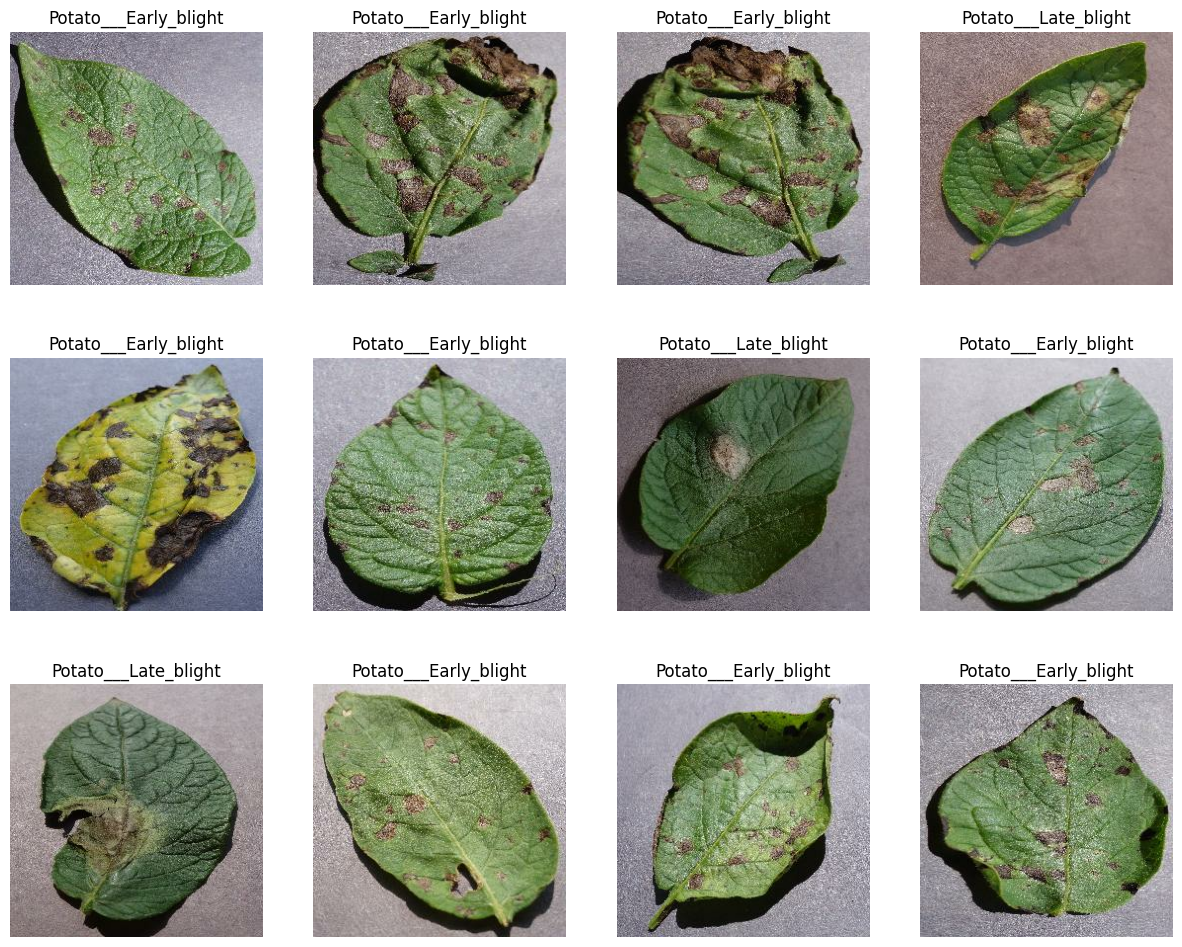

In [6]:
# Visualizing some of the images from our dataset

plt.figure(figsize=(15, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
# Function to split the data into train, validate and test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [10]:
# Cache, Shuffle, and Prefetch the Dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Creating a Layer for Resizing and Normalization

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=IMAGE_SIZE, width=IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)  # Normalization to [0, 1] range
])

In [15]:
# Data Augmentataion

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip input images horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),  # Randomly rotate input images by 20% (0.2 * 2 * π radians)
    tf.keras.layers.RandomZoom(0.2),  # Randomly zoom into the image by up to 20%
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)  # Randomly translate images by 10% of height and width
])

In [16]:
# Applying Data Augmentation to Train Dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# Model Architecture

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compiling the Model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
# Fitting the Model

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.4700 - loss: 0.9459 - val_accuracy: 0.4896 - val_loss: 0.9096
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.5789 - loss: 0.8209 - val_accuracy: 0.6719 - val_loss: 0.7096
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 833ms/step - accuracy: 0.7261 - loss: 0.6165 - val_accuracy: 0.7292 - val_loss: 0.5514
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 828ms/step - accuracy: 0.8126 - loss: 0.4355 - val_accuracy: 0.7135 - val_loss: 0.7402
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 802ms/step - accuracy: 0.8845 - loss: 0.2808 - val_accuracy: 0.7604 - val_loss: 0.8264
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 822ms/step - accuracy: 0.8878 - loss: 0.2974 - val_accuracy: 0.6927 - val_loss: 0.6061
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 801ms/step - accuracy: 0.8715 - loss: 0.3068 - val_accuracy: 0.8281 - val_loss: 0.4628
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 798ms/step - accuracy: 0.9460 - loss: 0.1390 - val_accuracy

In [22]:
# Evaluating the Model on Test Data

scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9396 - loss: 0.1380


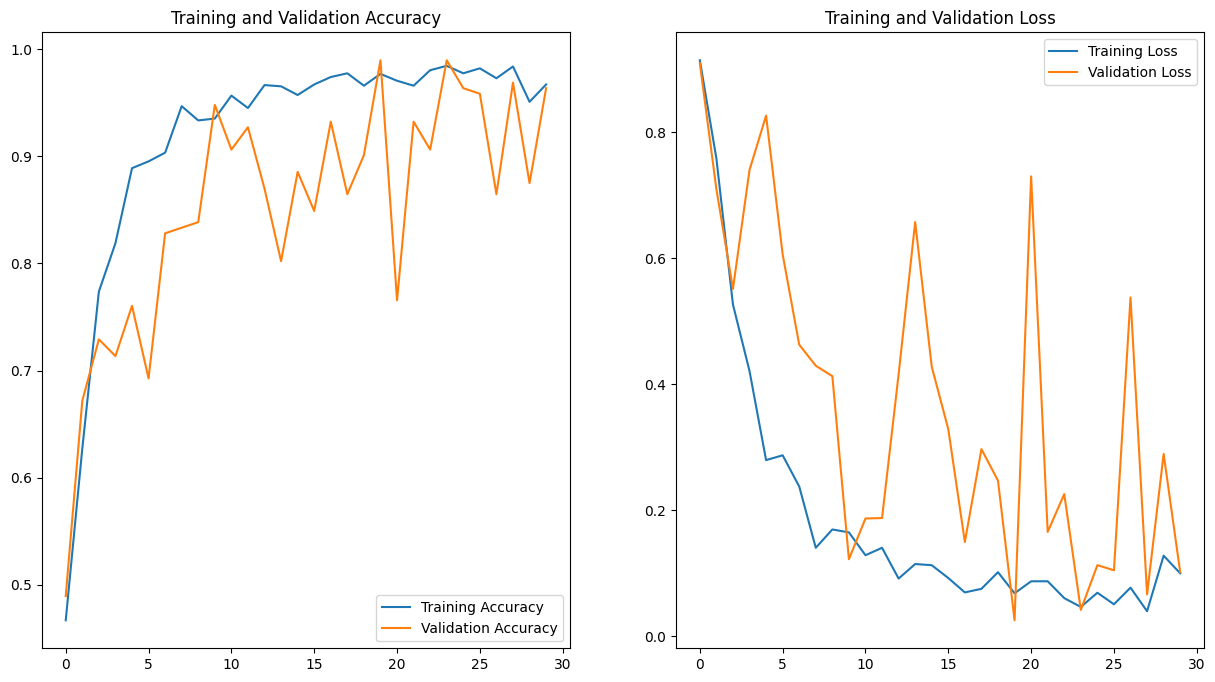

In [25]:
# Plotting the Accuracy and Loss Curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
# Saving the Model

import os
model_version=max([int(i) for i in os.listdir("./Models") + [0]])+1
model.save(f"./Models/{model_version}.keras")